In [1]:
import os
# Set environment variable to suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from src.neural_networks.get_data import get_tf_data, stack_1d_features, normalize_1d_features_with_mean_std, load_cv_data, make_importance_sampling_dataset
from src.neural_networks.nn_forecast import NNForecast
from src.visualization.twcrpss_plot import make_twcrpss_plot_tf
from src.visualization.brier_score import make_brier_skill_plot_tf
from src.visualization.pit import make_cpit_diagram_tf, comp_multiple_pit_scores
from src.visualization.reliability_diagram import make_reliability_and_sharpness_tf
from src.training.training import load_model
from src.visualization.plot_forecasts import plot_forecast_pdf_tf
from src.climatology.climatology import Climatology
from src.visualization.brier_score import get_brier_scores_tf
from src.models.emos import BootstrapEmos, EMOS
from src.neural_networks.get_data import get_fold_is
from src.visualization.brier_score import make_bootstrap_brier


import sklearn

from scipy.stats import norm, pareto

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pickle
import optuna

In [2]:
all_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

location_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

scale_features = ['wind_speed', 'press', 'kinetic', 'humid', 'geopot']

features_names_dict = {name: 1 for name in all_features}

features_names_dict['wind_speed'] = 15

ignore = ['229', '285', '323']

In [3]:
bounds = {7.5: 1, 9: 3, 12: 4, 15: 9, 100: 15}
fold_nr = 3
batch_size = 32

train_data, train_data_is2, test_data = get_fold_is(features_names_dict, fold_nr, bounds, batch_size, False)

tf.Tensor(28595, shape=(), dtype=int64)
tf.Tensor(15733, shape=(), dtype=int64)


In [101]:
loss = "loss_CRPS_sample"
#loss = "loss_cPIT"
samples = 300

# possible chain functions: 'chain_function_indicator' and 'chain_function_normal_cdf'
# if chain_function_indicator is chosen, threshold is not necessary
# if chain_function_normal_cdf is chosen, threshold is necessary
chain_function = "chain_function_normal_cdf_plus_constant"
threshold = 100
chain_function_mean = 9
chain_function_std = 0.5
chain_function_constant = 0.001


# possible optimizers: 'SGD', 'Adam'
optimizer = "Adam"
learning_rate = 0.01

# possible forecast distributions: 'distr_trunc_normal', 'distr_log_normal', 'distr_gev' and 'distr_mixture'/'distr_mixture_linear', which can be a mixture distribution of two previously mentioned distributions.
forecast_distribution = "distr_trunc_normal"

# necessary in case of a mixture distribution
distribution_1 = "distr_trunc_normal"
distribution_2 = "distr_log_normal"

random_init = False
printing = True
subset_size = None

setup = {'loss': loss,
         'samples': samples, 
         'optimizer': optimizer, 
         'learning_rate': learning_rate, 
         'forecast_distribution': forecast_distribution,
         'chain_function': chain_function,
         'threshold': threshold,
         'distribution_1': distribution_1,
         'distribution_2': distribution_2,
         'chain_function_mean': chain_function_mean,
         'chain_function_std': chain_function_std,
         'chain_function_constant': chain_function_constant,
         'all_features': all_features,
         'location_features': location_features,
         'scale_features': scale_features,
         'random_init': random_init,
         'subset_size': subset_size,
        'printing': printing,
         }

In [102]:
emos_is = EMOS(setup)

emos_base = EMOS(setup)

emos_is_2 = EMOS(setup)

In [103]:
epochs = 2

losses_is_2 = emos_is_2.fit(train_data_is2, epochs, True, test_data)['validation_loss']

Epoch:  0  Loss:  0.71784997
Epoch:  1  Loss:  0.499075621


In [104]:
epochs = 4

losses = emos_base.fit(train_data, epochs, True, test_data)['validation_loss']

Epoch:  0  Loss:  1.64428115
Epoch:  1  Loss:  0.913287938
Epoch:  2  Loss:  0.906776905
Epoch:  3  Loss:  0.906858623


In [106]:
setup['loss'] = 'loss_twCRPS_sample'

In [107]:
emos_weight_is = EMOS(setup)

emos_weight_base = EMOS(setup)

In [108]:
emos_weight_is_2 = EMOS(setup)

In [109]:
epochs = 2

losses_is_w2 = emos_weight_is_2.fit(train_data_is2, epochs, True, test_data)['validation_loss']

Epoch:  0  Loss:  0.10801775
Epoch:  1  Loss:  0.0919018


In [110]:
epochs = 4

losses_w = emos_weight_base.fit(train_data, epochs, True, test_data)['validation_loss']

Epoch:  0  Loss:  0.245490596
Epoch:  1  Loss:  0.171364039
Epoch:  2  Loss:  0.168228522
Epoch:  3  Loss:  0.167547509


In [4]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/base_emos_fold_3'

filepath2 = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/tn_ln_M13_STD2_C07.pkl'

with open(filepath, 'rb') as f:
    emos_base = EMOS(pickle.load(f))

with open(filepath2, 'rb') as f:
    emos_weight = EMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [ ]:
print(emos_base.CRPS(test_data, 1000))

print(emos_weight.CRPS(test_data, 1000))

0.8878092
0.8905406


In [ ]:
print(emos_base.twCRPS(test_data, [12], 10000))

print(emos_weight.twCRPS(test_data, [12], 10000))

[0.06270537]
[0.0623012]


In [5]:
models = {'emos_weight': emos_weight}

(1000, 40)
(40,)


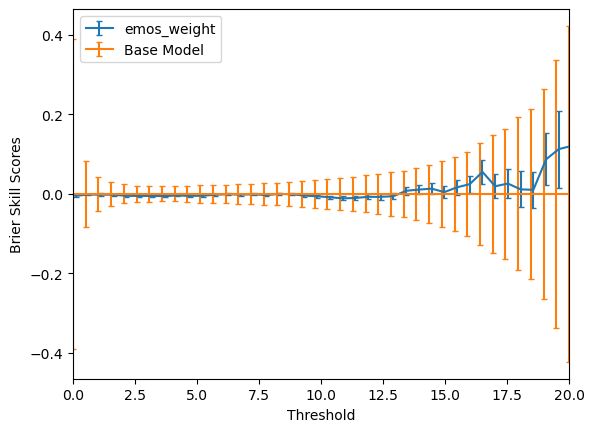

In [ ]:
values = np.linspace(0, 20, 40)


make_bootstrap_brier(emos_base, models, test_data, values, bootstrap_size = 1000)

In [113]:
train_data_original, test_data, data_info = load_cv_data(0, features_names_dict)

train_data = train_data_original.batch(len(train_data_original))

X_full, y_full = next(iter(train_data))

In [120]:
bounds = {7.5: 1, 9: 3, 12: 4, 15: 9, 100: 15}
fold_nr = 0
batch_size = 32

train_data, train_data_is_full, test_data = get_fold_is(features_names_dict, fold_nr, bounds, batch_size)

train_data_is_full = train_data_is_full.unbatch()

train_data_is_full = train_data_is_full.batch(100000)

X_is, y_is, w_is = next(iter(train_data_is_full))

print(y_is.shape)

tf.Tensor(43864, shape=(), dtype=int64)
tf.Tensor(23513, shape=(), dtype=int64)
(43864,)


In [147]:
filepath = '/net/pc200239/nobackup/users/hakvoort/hyperopt/hyperopt_emos/'

study = optuna.load_study(study_name='MOTPE_CRPS_CRPS12_linear_constant_from_zero', storage=f'sqlite:///{filepath}/study.db')
study.set_metric_names(['CRPS', 'twCRPS12'])

/tmp/ipykernel_785763/2842926713.py:4: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(['CRPS', 'twCRPS12'])


In [148]:
df = study.trials_dataframe()

new_column_names = {
    'params_chain_function_mean': 'cf_mean',
    'params_chain_function_std': 'cf_std',
    'params_chain_function_constant': 'cf_constant',
    'values_CRPS': 'CRPS',
    'values_twCRPS12': 'twCRPS12',
    'params_forecast_distribution': 'forecast_distribution',
    'params_distribution_2': 'distribution_2',
}

df.rename(columns=new_column_names, inplace=True)

In [149]:
df = df[0: 180]

In [150]:
length = 8
top_CRPS = df.sort_values('CRPS').head(length)
top_twCRPS12 = df.sort_values('twCRPS12').head(length)

In [151]:
pareto_front = study.best_trials
best_runs = [trial.number for trial in pareto_front]

pareto_trials = df['number'].isin(best_runs)

my_run = df[pareto_trials]

my_run = my_run.sort_values('CRPS')

In [152]:
all_params = ['cf_mean',
           'cf_std', 
           'cf_constant',
             'forecast_distribution', 
              'distribution_2',
                'CRPS',
             'twCRPS12',
             ]

In [6]:
filepath1 = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/base_emos_fold_1'

with open(filepath1, 'rb') as f:
    emos1 = EMOS(pickle.load(f))

filepath2 = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/base_emos_fold_2'

with open(filepath2, 'rb') as f:
    emos2 = EMOS(pickle.load(f))

filepath3 = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/base_emos_fold_3'

with open(filepath3, 'rb') as f:
    emos3= EMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution


In [11]:
train_data_load, test_data1, ignore = load_cv_data(1, features_names_dict)

ignore, test_data2, ignore = load_cv_data(2, features_names_dict)

ignore, test_data3, ignore = load_cv_data(3, features_names_dict)

test_data1 = test_data1.batch(test_data1.cardinality())

test_data2 = test_data2.batch(test_data2.cardinality())

test_data3 = test_data3.batch(test_data3.cardinality())

train_data_load = train_data_load.batch(32)



In [22]:
def eval_model(name):
    filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/' + name
    filepath1 = filepath + '1'

    filepath2 = filepath + '2'

    filepath3 = filepath + '3'

    with open(filepath1, 'rb') as f:
        emos1 = EMOS(pickle.load(f))

    with open(filepath2, 'rb') as f:
        emos2 = EMOS(pickle.load(f))

    with open(filepath3, 'rb') as f:
        emos3 = EMOS(pickle.load(f))

    ignore, test_data1, ignore = load_cv_data(1, features_names_dict)

    ignore, test_data2, ignore = load_cv_data(2, features_names_dict)

    ignore, test_data3, ignore = load_cv_data(3, features_names_dict)

    test_data1 = test_data1.batch(test_data1.cardinality())

    test_data2 = test_data2.batch(test_data2.cardinality())

    test_data3 = test_data3.batch(test_data3.cardinality())

    total_crps = (emos1.CRPS(test_data1, 90000) + emos2.CRPS(test_data2, 90000) + emos3.CRPS(test_data3, 90000)) / 3

    total_twcrps12 = (emos1.twCRPS(test_data1, [12], 90000) + emos2.twCRPS(test_data2, [12], 90000) + emos3.twCRPS(test_data3, [12], 90000)) / 3

    return total_crps, total_twcrps12[0]

In [16]:
total_crps = (emos1.CRPS(test_data1, 90000) + emos2.CRPS(test_data2, 90000) + emos3.CRPS(test_data3, 90000)) / 3

In [18]:
total_twcrps12 = (emos1.twCRPS(test_data1, [12], 90000) + emos2.twCRPS(test_data2, [12], 90000) + emos3.twCRPS(test_data3, [12], 90000)) / 3

In [31]:
best_model_crps, best_model_twcrps = eval_model('top_twcrps_tn_')

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution


In [23]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/top_twcrps_tn_3'

with open(filepath, 'rb') as f:
    emos165 = EMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/top_twcrps_3'

with open(filepath, 'rb') as f:
    emos24 = EMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/top_twcrps_ln_3'

with open(filepath, 'rb') as f:
    emos66 = EMOS(pickle.load(f))

filepath = '/net/pc200239/nobackup/users/hakvoort/models/emos_tf/pareto_front_82_3'

with open(filepath, 'rb') as f:
    emos82 = EMOS(pickle.load(f))

Using given parameters for Truncated Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Generalized Extreme Value distribution
Using given weight parameters for weights in Mixture Linear distribution
Using given parameters for Log Normal distribution
Using given parameters for Truncated Normal distribution
Using given parameters for Log Normal distribution
Using given weight parameters for weights in Mixture Linear distribution


In [28]:
best_models = {'Model 165': emos165, "Model 24": emos24, 'Model 66': emos66, 'Model 82': emos82}

model_climatology = {'Model 165': emos165, 'Model 82': emos82, 'Base Emos': emos_base}

In [29]:
folder = '/net/pc200239/nobackup/users/hakvoort/models/climatology/climatology_cv_3'

climatology = Climatology.load(folder)

In [12]:
filepath = '/net/pc200239/nobackup/users/hakvoort/models/conv_nn/'

cnn1 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_80_1', train_data_load)

cnn2 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_80_2', train_data_load)

cnn3 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_80_3', train_data_load)

cnn4 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_80_4', train_data_load)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step


/usr/people/hakvoort/.local/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 118 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 610ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 601ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 713ms/step


In [13]:
cnn_is_1 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_80_is_1', train_data_load)

cnn_is_2 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_80_is_2', train_data_load)

cnn_is_3 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_80_is_3', train_data_load)

cnn_is_4 = NNForecast.my_load(filepath + 'CRPS_trunc_normal_epochs_80_is_4', train_data_load)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step


In [16]:
all_cnn_models = {'us_1': cnn1, 'us_2': cnn2, 'us_3': cnn3, 'us_4': cnn4,
                  'is_1': cnn_is_1, 'is_2': cnn_is_2, 'is_3': cnn_is_3, 'is_4': cnn_is_4}

best_cnn_models = {'Uniform Sampling': cnn2, 'Importance Sampling': cnn_is_2}

In [ ]:
twcrps1 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_1', train_data_load)

twcrps2 = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_2', train_data_load)

twcrps1_is = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_1', train_data_load)

twcrps2_is = NNForecast.my_load(filepath + 'twCRPS_mean_9_std_0.25_constant_0.01_trunc_normal_epochs_200_is_2', train_data_load)

In [ ]:
twcrps_cnn_models = {'us_1': twcrps1, 'us_2': twcrps2, 'is_1': twcrps1_is, 'is_2': twcrps2_is}

## Work of the last 3 weeks

- Implemented constraint for mixture linear model

- Ran MOTPE with smaller search space 

- Worked on importance sampling

- Implemented bootstrapping

- Worked on the GEV distribution for CNNs

#### Constraint for Mixture Linear Model

For the mixture linear I defined the weight by 

$w = \sigma(\alpha + \beta X_w)$

where $\sigma$ is the sigmoid function. I now set the following contraints:

$\alpha \in [4,12] \quad\text{and} \quad\beta \in [-6,-0.6]$

Now all models will use the TN for lower wind speeds and LN/GEV for higher wind speeds


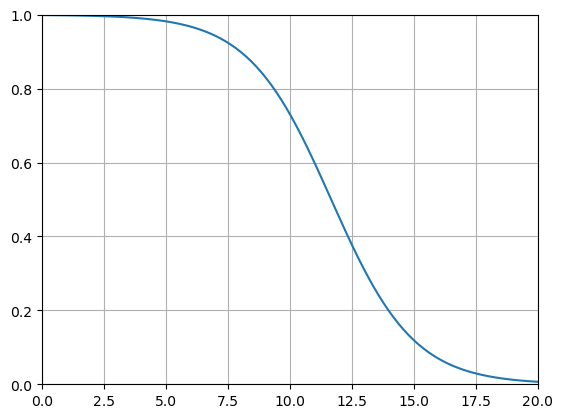

In [30]:
alpha = 7
beta = -0.6
x = np.linspace(0, 20, 200)

y = 1 / (1 + np.exp(-(alpha + beta * x)))
plt.plot(x, y)
plt.xlim(0,20)
plt.ylim(0,1)
plt.grid()
plt.show()

#### Results for Hyperparamter Optimization

I reduced the size of the search space. I fixed the following parameters:

- Batch size to 256

- 450 epochs

- Adam optimizer

- Learning rate of 0.01

Did multiple runs, and the results were all very similar. In general, t

- The mixture linear distribution with TN-GEV, combined with a scoring rule that did not focus on extremes was best at minimizing CRPS. 

- Any distribution with a scoring rule focusing on extremes was best at miniziming twCRPS12

- For the pareto front, mixture linear distributions were used with different weighted scoring rules.

In [153]:
display(top_CRPS[all_params])

,cf_mean,cf_std,cf_constant,forecast_distribution,distribution_2,CRPS,twCRPS12
24,8.014864,0.051787,0.905043,distr_mixture_linear,distr_gev,0.899754,0.059584
32,2.381427,0.000149,0.846054,distr_mixture_linear,distr_gev,0.900814,0.059747
69,7.214490,5.441655,0.245422,distr_mixture_linear,distr_gev,0.900886,0.059634
74,11.130756,9.455881,0.088957,distr_mixture_linear,distr_gev,0.900919,0.059736
45,4.450143,4.945555,0.413133,distr_mixture_linear,distr_gev,0.901207,0.059513
160,0.429430,1.295928,0.031033,distr_mixture_linear,distr_gev,0.901321,0.059876
89,7.510774,1.363924,0.396717,distr_mixture_linear,distr_gev,0.901359,0.059626
176,8.184592,0.047243,0.860618,distr_trunc_normal,NaN,0.901405,0.059753


In [154]:
display(top_twCRPS12[all_params])

,cf_mean,cf_std,cf_constant,forecast_distribution,distribution_2,CRPS,twCRPS12
51,9.649472,1.084596,0.001125,distr_mixture_linear,distr_gev,0.936089,0.059160
167,8.063486,0.427858,0.062220,distr_trunc_normal,NaN,0.910241,0.059180
66,9.860208,0.301864,0.000522,distr_log_normal,NaN,1.019796,0.059257
165,8.830960,1.068426,0.015801,distr_trunc_normal,NaN,0.921362,0.059311
30,9.571495,0.005566,0.004899,distr_mixture_linear,distr_log_normal,0.937670,0.059344
82,7.050564,2.405172,0.061703,distr_mixture_linear,distr_log_normal,0.904452,0.059380
115,9.578896,0.507889,0.026211,distr_gev,NaN,0.922650,0.059393
10,8.242517,0.047522,0.030665,distr_mixture,distr_log_normal,0.919068,0.059395


In [155]:
display(my_run[all_params])

,cf_mean,cf_std,cf_constant,forecast_distribution,distribution_2,CRPS,twCRPS12
24,8.014864,0.051787,0.905043,distr_mixture_linear,distr_gev,0.899754,0.059584
45,4.450143,4.945555,0.413133,distr_mixture_linear,distr_gev,0.901207,0.059513
162,9.614099,0.077247,0.925251,distr_mixture_linear,distr_log_normal,0.902346,0.059471
82,7.050564,2.405172,0.061703,distr_mixture_linear,distr_log_normal,0.904452,0.059380
167,8.063486,0.427858,0.062220,distr_trunc_normal,NaN,0.910241,0.059180
51,9.649472,1.084596,0.001125,distr_mixture_linear,distr_gev,0.936089,0.059160


In [32]:
print(best_model_crps)
print(best_model_twcrps)

0.9217993418375651
0.05931676303346952


In [20]:
print('CRPS for model trained on CRPS with TN: ', total_crps)
print('twCRPS12 for model trained on CRPS with TN: ', total_twcrps12[0])

CRPS for model trained on CRPS with TN:  0.9043865203857422
twCRPS12 for model trained on CRPS with TN:  0.06061019872625669


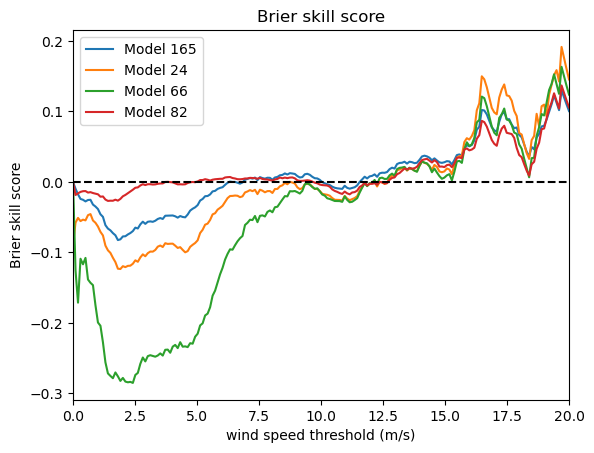

In [25]:
values = np.linspace(0,20, 200)
make_brier_skill_plot_tf(emos_base, best_models, test_data3, values)

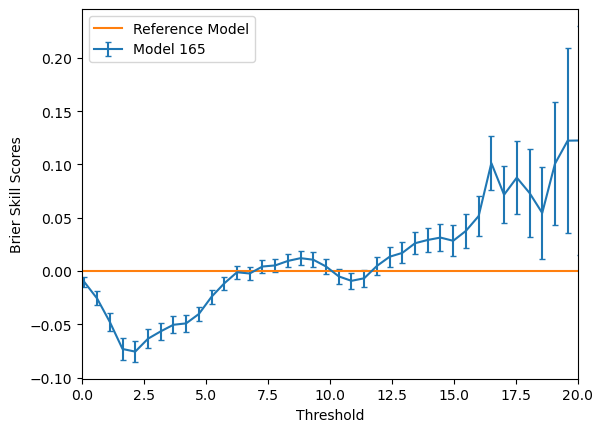

In [10]:
values = np.linspace(0,20, 40)
make_bootstrap_brier(emos_base, best_models, test_data3, values, name_base_model='Emos Base')

In [30]:
values = np.linspace(0, 20, 40)

make_bootstrap_brier(climatology, model_climatology, test_data3, values, name_base_model='Climatology')

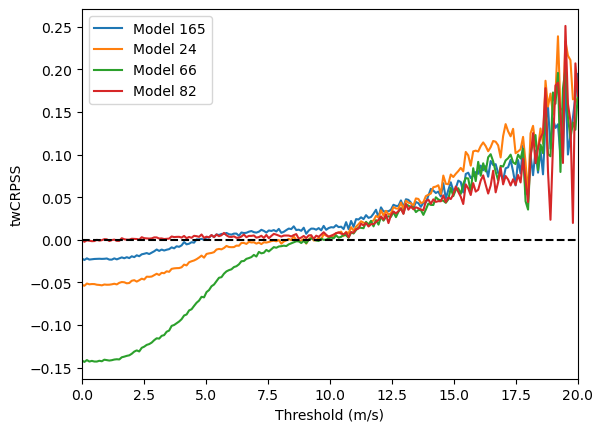

In [26]:
make_twcrpss_plot_tf(emos_base, best_models, test_data3, values)

#### GEV Distribution

Because the GEV distribution was deemed good in hyperparmater optimization for linear regression, I implemented it for CNNs. However, sometimes it is unstable (depending on the initialization) and the gradients become NaN or the loss becomes negative.

During hyperopt, I could implement a loop such that it keeps training models until it has 'good' performance or I could take some more time to try and fix it. Last option is to keep only TN, ML and a mixture of TN-LN.  

#### Implemented Importance Sampling

Made 5 sets, depending on the observation. Then upsampled from these with the following factors:

- Less than 7.5: 1

- Between 7.5 and 9: 3

- Between 9 and 12: 4

- Between 12 and 15: 9

- Greater than 15: 15



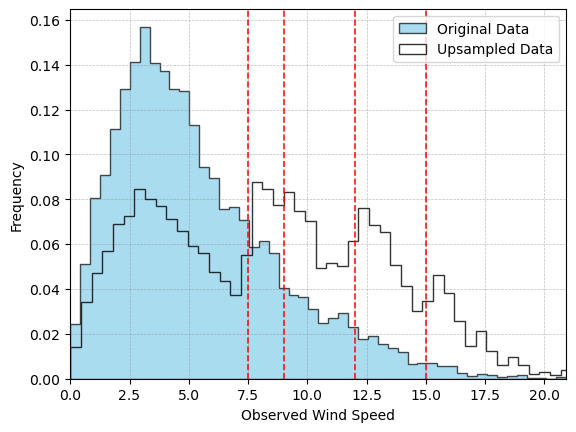

In [139]:
plt.hist(y, bins = 50, density=True, color='skyblue', edgecolor='black', alpha=0.7, label='Original Data', histtype='stepfilled')
plt.hist(y_is, bins = 50, density=True, color='orange', edgecolor='black', alpha=0.8, label='Upsampled Data', histtype='step')

plt.xlim(0, np.max(y))
plt.xlabel('Observed Wind Speed')
plt.ylabel('Frequency')

plt.axvline(7.5, linestyle='--', color='red', alpha=0.9, linewidth=1.2)
plt.axvline(9, linestyle='--', color='red', alpha=0.9, linewidth=1.2)
plt.axvline(12, linestyle='--', color='red', alpha=0.9, linewidth=1.2)
plt.axvline(15, linestyle='--', color='red', alpha=0.9, linewidth=1.2)
plt.legend()

plt.grid(True, color='grey', linestyle='--', linewidth=0.5, alpha=0.5)
plt.show()

I then trained EMOS with linear regression on the two data sets, and checked the loss on the validation set every 0.5 seconds. I chose a batch size of 32 (which is the default in TensorFlow for training neural networks). All models have the TN as parametric distribution. I chose two different loss functions.

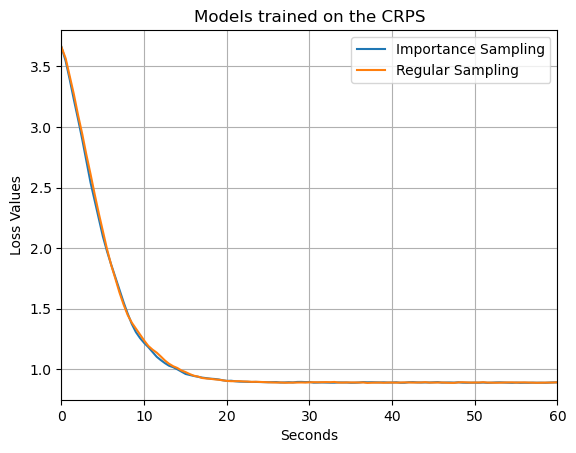

In [141]:
plt.plot(list(losses_is_2.keys()), list(losses_is_2.values()), label='Importance Sampling')
plt.plot(list(losses.keys()), list(losses.values()), label='Regular Sampling')
plt.xlabel('Seconds')
plt.ylabel("Loss Values")
plt.xlim(0, 60)
plt.grid()
plt.legend()
plt.title("Models trained on the CRPS")
plt.show()

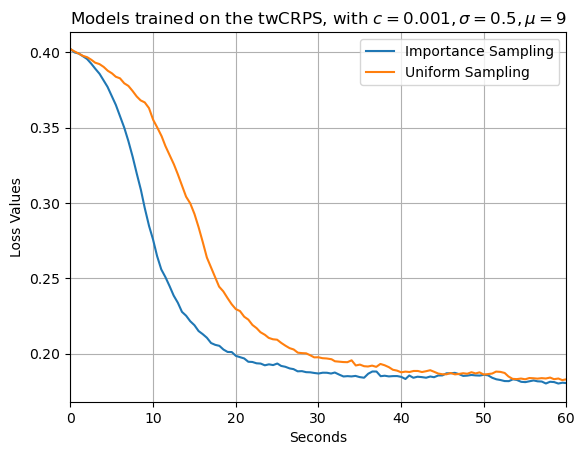

In [146]:
plt.plot(list(losses_is_w2.keys()), list(losses_is_w2.values()), label='Importance Sampling')
plt.plot(list(losses_w.keys()), list(losses_w.values()), label='Uniform Sampling')
plt.xlabel('Seconds')
plt.ylabel("Loss Values")
plt.grid()
plt.xlim(0, 60)
plt.legend()
plt.title(r"Models trained on the twCRPS, with $c=0.001, \sigma=0.5, \mu=9$")
plt.show()

With larger batch sizes the effect of importance sampling became smaller. One downside of using importance sampling is that the size of the data set increases, making the use of early stopping smaller.

In [125]:
print('Size of the original data set: ', y_full.shape)

Size of the original data set:  (23513,)


In [127]:
print('Size of the importance sampling data set: ', y_is.shape)

Size of the importance sampling data set:  (43864,)


#### Importance Sampling for CNNs

Also checked the efect of importance sampling on CNNs. I used the TN as parametric distribution and the models are trained on the CRPS. Since the dataset for importance sampling is larger, and with early stopping we only stop at the end of the epoch, I changed the size of an epoch for importance sampling such that it coincided with the original data size (meaning that every model gets the same number of updates before the validation error is computed)

Models with uniform sampling: approximately 23 epochs

Models with importance sampling: approximately 14 epochs

As reference model we used EMOS with linear regression trained on CRPS with TN distribution.

244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
244/244 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


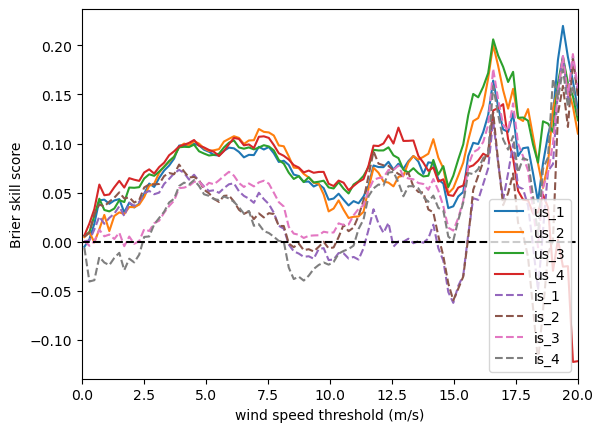

In [22]:
values = np.linspace(0.1, 20, 100)

brier_base_model = get_brier_scores_tf(emos_base, test_data3, values)
for model in all_cnn_models:
    brier_scores = get_brier_scores_tf(all_cnn_models[model], test_data3, values)
    brier_skill_scores = 1 - brier_scores / brier_base_model
    if model[:2] == 'us':
        plt.plot(values, brier_skill_scores, label = model)
    else:
        plt.plot(values, brier_skill_scores, label = model, linestyle='--')

# print a striped black horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')

plt.xlabel('wind speed threshold (m/s)')
plt.ylabel('Brier skill score')
plt.xlim(0, 20)
plt.title("Model trained on CRPS")
plt.legend()
plt.show()

I did something similar for models trained on the twCRPS. The weight function has parameters $c = 0.01, \mu = 9$ and $\sigma = 0.25$. 

The decrease in steps made before early stopping was now very significant, from around 60 epochs for uniform sampling to 10 epochs

In [ ]:
values = np.linspace(0.1, 20, 100)

brier_base_model = get_brier_scores_tf(emos_base, test_data3, values)
for model in twcrps_cnn_models:
    brier_scores = get_brier_scores_tf(twcrps_cnn_models[model], test_data3, values)
    brier_skill_scores = 1 - brier_scores / brier_base_model
    if model[:2] == 'us':
        plt.plot(values, brier_skill_scores, label = model)
    else:
        plt.plot(values, brier_skill_scores, label = model, linestyle='--')

# print a striped black horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')

plt.xlabel('wind speed threshold (m/s)')
plt.ylabel('Brier skill score')
plt.xlim(0, 20)
plt.title("Model trained on twCRPS")
plt.legend()
plt.show()

I do not really know how to proceed with importance sampling, since the effect differs based on the loss function, which makes hyperparameter optimization for the loss function much more difficult.

### Questions

- Daniel left out some of the stations in the training and test data because there were missing samples. I also left out these stations, should I keep it that way?

- For the TN and GEV distribution, I do not use the actual mean/variance for the distributions. For the TN is use the mean/std before truncation, for the GEV I use the loc and scale (similar to Lerch)

- For the mixture models: we get two sets of linear equations for the mean and two sets for the variance, that is correct right?

####

My plan is to to perform hyperparameter optimization for CNNs, where I first take a larger search space and after I have a good idea of 'good' parameters decrease the search space (similar to what I did for linear regression).

Then use the test set to evaluate the performance of the best models, then start writing the thesis (which I already started doing).